# FID

## Previous DDPM

In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial
from scipy import linalg

import timm
import einops
from fastcore.foundation import L
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim,Tensor
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()
toggle_mpl_cmap()

setting cmap: gray_r


In [17]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

xl,yl = 'image','label'

import torchvision.transforms.functional as TF

xmean,xstd = 0.286, 0.353

@inplace
def transformi(b): b[xl] = [TF.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [3]:
betamin, betamax, nsteps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, nsteps)
alpha = 1 - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

t = torch.randint(0, nsteps, (4,), dtype=torch.long)
alphabar_t = alphabar[t]

In [4]:
from tqdm.notebook import tqdm

def noisify(x0, alphabar):
    device = x0.device
    bs = len(x0)
    t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    # expanding each alphabar_t to a single item in the batch
    alphabar_t = alphabar[t][:, None, None, None]

    # weighted average of original image and noise
    xt = x0 * alphabar_t.sqrt() + (1 - alphabar_t).sqrt() * epsilon

    # noised image, timestep : epsilon (noise target)
    return xt, t.to(device), epsilon


@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, nsteps):
    device = next(model.parameters()).device
    xt = torch.randn(sz, device=device)
    preds = []

    for t in tqdm(list(reversed(range(nsteps)))):
        # contains a batch of items at time T. Starts at max (e.g. 1000) which is noise
        t_batch = torch.full((sz[0],), t, device=device, dtype=torch.long)

        if t == 0:  # final step, add no noise, use the image
            z = torch.zeros_like(xt, device=device)
            alphabar_t1 = torch.tensor(1)
        else:
            z = torch.randn_like(xt)
            alphabar_t1 = alphabar[t - 1]

        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        beta_t = 1 - alpha_t
        betabar_t = 1 - alphabar_t
        betabar_t1 = 1 - alphabar_t1
        sigma_t = sigma[t]

        noise_pred = model(xt, t_batch)  # previous image

        # attempting to completely remove the noise
        x0_hat = ( (xt - betabar_t.sqrt() * noise_pred) / alphabar_t.sqrt() ).clamp(-1, 1)

        # how much we keep of the estimated noise
        x0_coeff = alphabar_t1.sqrt() * beta_t / betabar_t

        # how much we keep of the previous image
        xt_ceoff = alpha_t.sqrt() * betabar_t1 / betabar_t

        added_noise = sigma_t * z

        # weighted average of the previous image and the estimated noise + added noise
        xt = x0_hat * x0_coeff + xt * xt_ceoff + added_noise

        # as we converge on t=0, our prediction of x0 will be more accurate,
        # so we weight x0_coeff and less xt_coeff

        preds.append(to_cpu(xt))
    return preds

In [5]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, xb, t):
        return super().forward(xb, t).sample # type: ignore

ddpm_model = torch.load("fashion_ddpm_25epochs_large.pkl")

  0%|          | 0/1000 [00:00<?, ?it/s]

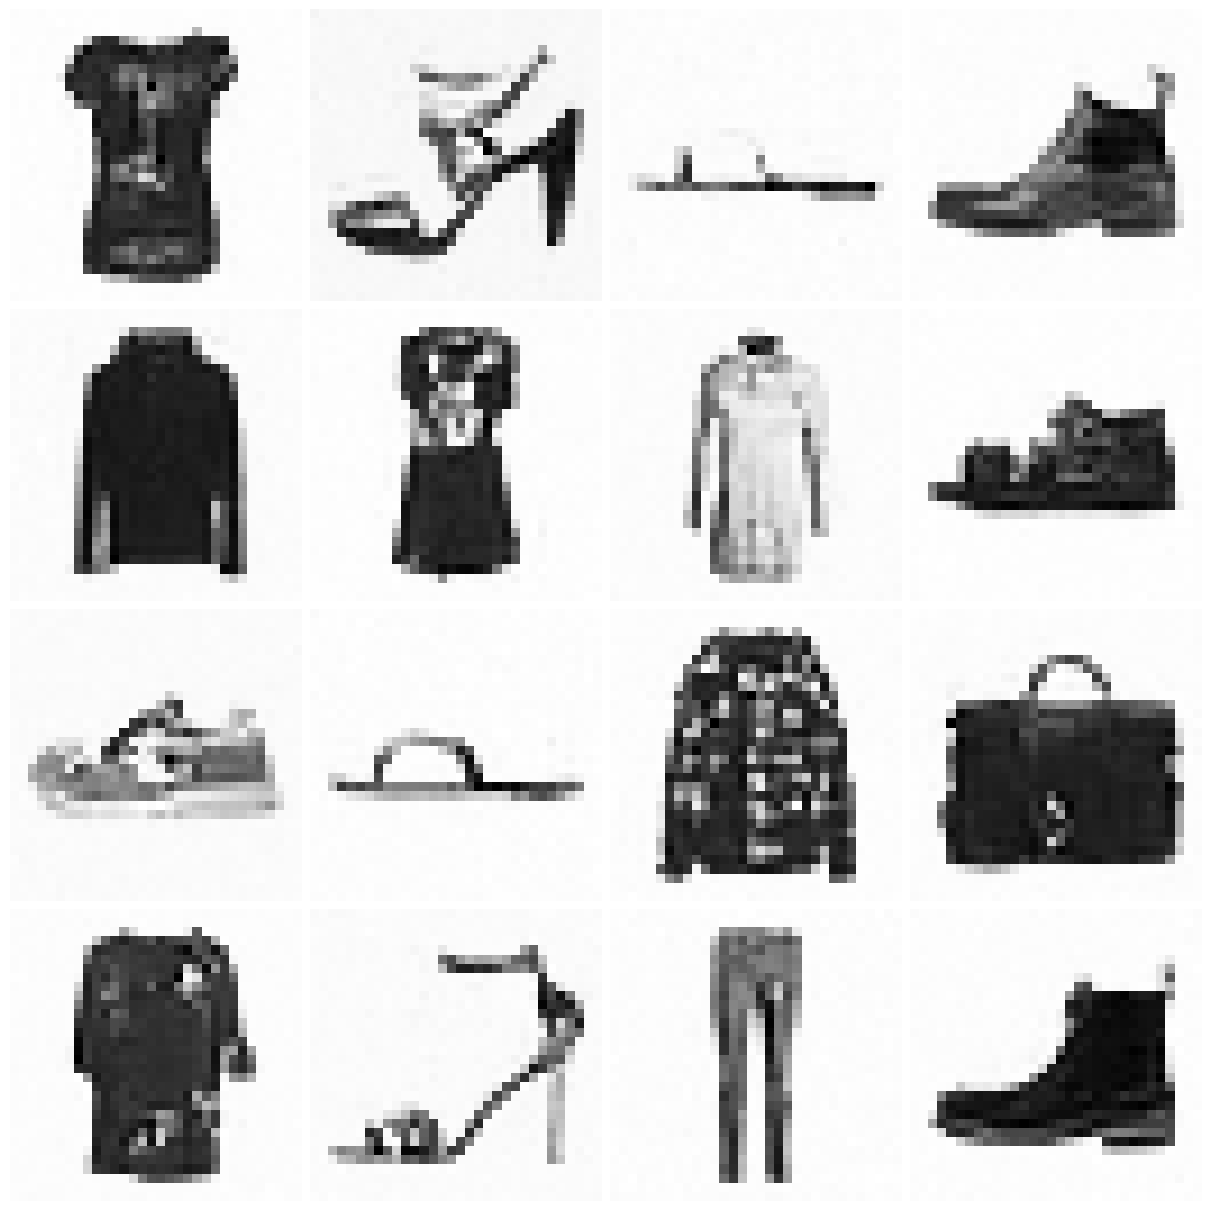

In [6]:
samples = sample(ddpm_model, (bs, 1, 32, 32), alpha, alphabar, sigma, 1000)
show_images(samples[-1][:16])

## FID for realz

In [18]:
s = samples[-1]
s.shape

torch.Size([256, 1, 32, 32])

In [19]:
def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.4

    layers = [
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm),
        nn.Dropout2d(p=0.1),
        ResBlock(16, 32, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=0.1),
        ResBlock(32, 64, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=0.2),
        ResBlock(64, 128, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=drop),
        ResBlock(128, 256, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=drop),
        ResBlock(256, 512, stride=2, act=act, norm=norm),
        # nn.Dropout(p=drop),
        nn.Flatten(),
        # nn.Linear(512, 10, bias=False),
        # nn.BatchNorm1d(10),
    ]
    return nn.Sequential(*layers)

clf_model = get_model().eval()

In [34]:
def always_zero(*x): return tensor(0., device=def_device)

learn = Trainer(clf_model, dls, loss_func=always_zero, cbs=[NBatchCB(1)])
learn.load("fashion-mnist-clf-dropout-aug.pkl", strict=False)

feats, _ = learn.capture_preds()

learn = Trainer(clf_model, DataLoaders([], [(s, torch.zeros(s.size(0)))]), always_zero)
learn.load("fashion-mnist-clf-dropout-aug.pkl", strict=False)

feats2, _ = learn.capture_preds()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

In [29]:
feats2.shape

torch.Size([256, 512])

In [30]:
feats.shape

torch.Size([256, 512])

In [31]:
def _calc_stats(feats):
    feats.squeeze_()
    return feats.mean(0), feats.T.cov()

def _calc_fid(m1, c1, m2, c2):
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()


Jeremey's was 33. Bug somewhere?

In [32]:
s1, s2 = _calc_stats(feats), _calc_stats(feats2)

_calc_fid(*s1, *s2)

4313.546875